# Variational autoencoder - CelebA

In [1]:
%pip install -r ../requirements.txt

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import (
    display_random,
    display_img
)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

sys.path.insert(0, '..')
from dataset import VAEDataset
from models import (
    Encoder,
    Decoder,
    VanillaVAE
)

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


## 0. Parameters

In [2]:
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 512
EPOCHS = 10
LR = 1e-4
KL_WEIGHT = 1e-4
LOAD_MODEL = True

## 1. Prepare the data

In [3]:
data_path = '../celeba/'

data = VAEDataset(data_path=data_path,
                  batch_size=BATCH_SIZE,
                  num_workers=16,
                  pin_memory=True)
# Uncomment if you haven't downloaded the dataset.
# data.prepare_data()
data.setup()

## 2. Build VAE

In [4]:
encoder = Encoder(in_channels=3,
                  z_dim=512)
decoder = Decoder(z_dim=512)
vanilla_vae = VanillaVAE(lr=LR,
                         beta=KL_WEIGHT,
                         encoder=encoder,
                         decoder=decoder)

## 3. Train VAE

In [8]:
if LOAD_MODEL:
    vae = VanillaVAE.load_from_checkpoint("../logs/VanillaVAE/version_8/checkpoints/epoch=39-step=50880.ckpt",
                                          lr=1e-4,
                                          beta=1e-4,
                                          encoder=Encoder(in_channels=3, z_dim=512),
                                          decoder=Decoder(z_dim=512))
else:
    """
    It's been noticed that progress bar in bugges in Jupyter Notebook.
    You can try training the model with train.py
    """
    tb_logger = TensorBoardLogger(save_dir='logs/', name='Vanilla VAE')
    trainer = Trainer(logger=tb_logger,
                      accelerator='auto',
                      devices=1,
                      max_epochs=EPOCHS)
    trainer.fit(model=vanilla_vae, datamodule=data)

## 4. Tests

### Reconstructions

### Generated celebrities

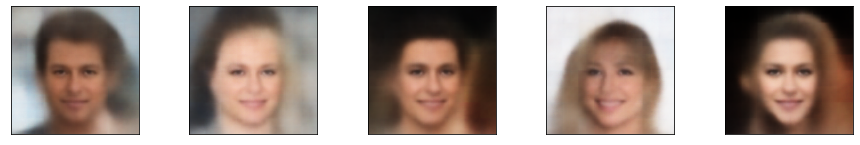

In [9]:
sample = torch.randn(5, Z_DIM).to('cuda')
display_img(vae.decode(sample).to('cpu'))